# Define the system  

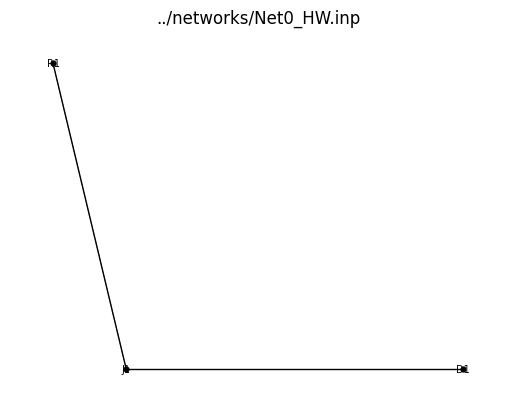

<Axes: title={'center': '../networks/Net0_HW.inp'}>

In [1]:
import wntr
import wntr_quantum

# Create a water network model
inp_file = '../networks/Net0_HW.inp'
# inp_file = 'networks/Net2Loops.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)


## Expression of he network

In [2]:
from wntr.sim.hydraulics import create_hydraulic_model
model, updater = create_hydraulic_model(wn)
print(model.__str__())


cons:
mass_balance[J1]:   ((expected_demand[J1]-flow[P1])+flow[P2])
mass_balance[D1]:   (expected_demand[D1]-flow[P2])
approx_hazen_williams_headloss[P1]:   (((((((-((sign(flow[P1]))))*hw_resistance[P1])*((abs(flow[P1]))**1.852))-((1e-05*(hw_resistance[P1]**0.5))*flow[P1]))-(((sign(flow[P1]))*minor_loss[P1])*(flow[P1]**2.0)))+source_head[R1])-head[J1])
approx_hazen_williams_headloss[P2]:   (((((((-((sign(flow[P2]))))*hw_resistance[P2])*((abs(flow[P2]))**1.852))-((1e-05*(hw_resistance[P2]**0.5))*flow[P2]))-(((sign(flow[P2]))*minor_loss[P2])*(flow[P2]**2.0)))+head[J1])-head[D1])

vars:
flow[P1]:   flow[P1]
flow[P2]:   flow[P2]
head[J1]:   head[J1]
head[D1]:   head[D1]



In [3]:
print(model.expected_demand['J1'].value)
print(model.expected_demand['D1'].value)
print(model.hw_resistance['P1'].value)
print(model.hw_resistance['P2'].value)
print(model.source_head['R1'].value)

0.0
0.05
234518508.2718721
10512430570.450115
30.0


In [11]:
import numpy as np

hw_res_list = [ {'P1':1.0, 'P2':1.0}, {'P1':2.0, 'P2':1.0}, {'P1':1.0, 'P2':2.0}, {'P1':2.0, 'P2':2.0}]
exp_dem = {'J1':-1, 'D1':1}
src_hd = {'R1':2.0}

def network_function(input):
    
    flow = {'P1':input[0], 'P2':input[1]}
    head = {'J1':input[2], 'D1':input[3]}

    def mb_j1(flow):
        return exp_dem['J1'] - flow['P1'] + flow['P2']
    
    def mb_d1(flow):
        return exp_dem['D1'] - flow['P2']
    
    def hl_p1(head, flow):
        return -hw_res['P1']*flow['P1']**2 + src_hd['R1'] - head['J1']

    def hl_p2(head, flow):
        return -hw_res['P2']*flow['P2']**2 + head['J1'] - head['D1']
    
    return np.array([
        mb_j1(flow),
        mb_d1(flow),
        hl_p1(head, flow),
        hl_p2(head, flow)
    ])


In [12]:
from quantum_newton_raphson.newton_raphson import newton_raphson
res = []
for hw_res in hw_res_list:
    initial_point = np.random.rand(4)
    res.append(newton_raphson(network_function, initial_point))
    assert np.allclose(network_function(res[-1].solution), 0)

/home/nico/QuantumApplicationLab/QuantumNewtonRaphson/quantum_newton_raphson/utils.py:74: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn("spsolve requires A be CSC or CSR matrix format", SparseEfficiencyWarning)


In [13]:
res

[NewtonRaphsonResult(solution=array([4.951e-22, 1.000e+00, 2.000e+00, 1.000e+00]), n_iter=2, diff=5.0058845957323683e-11, converged=True, linear_solver_results=[SPLUResult(solution=array([ 0.647, -0.356, -1.483, -1.497]), splu=<SuperLU object at 0x72d560a5a660>), SPLUResult(solution=array([-1.173e-12,  9.526e-12,  4.181e-01,  5.448e-01]), splu=<SuperLU object at 0x72d560ae8a50>)]),
 NewtonRaphsonResult(solution=array([-8.327e-17,  1.000e+00,  2.000e+00,  1.000e+00]), n_iter=2, diff=1.169997432270975e-11, converged=True, linear_solver_results=[SPLUResult(solution=array([ 0.179, -0.4  , -1.64 , -0.272]), splu=<SuperLU object at 0x72d560a5a6f0>), SPLUResult(solution=array([5.139e-12, 1.071e-11, 6.387e-02, 2.241e-01]), splu=<SuperLU object at 0x72d560ae8ae0>)]),
 NewtonRaphsonResult(solution=array([-1.093e-16,  1.000e+00,  2.000e+00,  5.409e-14]), n_iter=2, diff=1.615062250603927e-12, converged=True, linear_solver_results=[SPLUResult(solution=array([ 0.138, -0.133, -1.629,  0.405]), splu=<

In [25]:
def define_problem():
    # system of equations
    num_equations = 5
    num_var = 6

    P0 = np.zeros(num_equations)
    P0[0] = exp_dem['J1']
    P0[1] = exp_dem['D1']
    P0[2] = src_hd['R1']
    P0[3] = 0
    P0[4] = 0

    P1 = np.zeros((num_equations, num_var))
    P1[0, 0] = -1
    P1[0, 1] =  1
    P1[0, 2] =  0 
    P1[0, 3] =  0

    P1[1, 0] =  0
    P1[1, 1] = -1
    P1[1, 2] =  0 
    P1[1, 3] =  0

    P1[2, 0] =  0
    P1[2, 1] =  0
    P1[2, 2] = -1 
    P1[2, 3] =  0

    P1[3, 0] =  0
    P1[3, 1] =  0
    P1[3, 2] =  1 
    P1[3, 3] = -1

    P1[4,4] = 1
    P1[4,5] = 1
   

    P2 = np.zeros((num_equations, num_var, num_var))
    P3 = np.zeros((num_equations, num_var, num_var, num_var))
    P3[2, .., ..] = -1
    P3[3, .., ..] = -1 

    # search parameters
    qubits_per_var = 2
    basis = np.array([2**i for i in range(qubits_per_var)])

    # basis_offset = np.array([-0.5, 1])
    # basis_coeff = np.array([0.5, 1])

    basis_offset = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    basis_coeff = np.array([1, 1, 1, 1, 1, 1])

    basis_map = {
        "basis": basis,
        "basis_offset": basis_offset,
        "basis_coeff": basis_coeff,
    }

    return (
        num_equations,
        num_var,
        P0,
        P1,
        P2,
        P3,
        qubits_per_var,
        basis,
        basis_offset,
        basis_coeff,
        basis_map,
    )

In [26]:
from poly_brute_force import solve
sol = solve(define_problem)

extended qubo
ground state eigenvector =  [0. 0. 1. 0. 0. 1. 1. 0.]
ground state eigenvalue  =  0.0
solution                 =  [0.0, 1.0, 2.0, 1.0]

upper triangular qubo
ground state eigenvector =  [0. 0. 1. 0. 0. 1. 1. 0.]
ground state eigenvalue  =  0.0
solution                 =  [0.0, 1.0, 2.0, 1.0]

reduced upper triangular qubo
ground state eigenvector =  [0. 0. 1. 0. 0. 1. 1. 0.]
ground state eigenvalue  =  0.0
solution                 =  [0.0, 1.0, 2.0, 1.0]

